In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Dense, Dropout, Lambda, BatchNormalization, GlobalAveragePooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pickle
import gzip
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight
import matplotlib.pyplot as plt


# Load in dataframe
This df contains atomic features, soap descriptors, and bandgap

In [88]:
data_path = "/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/soap_and_atomic_features.pkl.gz"
# Step 1: Read the compressed pickle
with gzip.open(data_path, 'rb') as f:
    data_df = pickle.load(f)

print(data_df.shape)
# data_df = data_df[data_df['gap opt'] >= 0.2]
data_df = data_df.dropna()
print(data_df.shape)
data_df.head()

(5358, 25)
(5352, 25)


,formula,mpid,gap opt,padded_soap,soap_flat,electronegativity_mean,electronegativity_max,electronegativity_min,electronegativity_std,atomic_radius_mean,...,ionenergies_min,ionenergies_std,covalent_radius_mean,covalent_radius_max,covalent_radius_min,covalent_radius_std,nvalence_mean,nvalence_max,nvalence_min,nvalence_std
0,MgAlPO5,mp-6596,5.2711,"[[7.834700877986906e-05, -0.000248821014237357...","[7.834700877986906e-05, -0.0002488210142373574...",2.78875,3.44,1.31,0.815824,84.375,...,5.985769,2.902622,86.375000,139,63,28.752174,5.000000,6,2,1.581139
1,KBePO4,mp-7324,5.6141,"[[1.224395792223083e-07, -5.548160208843811e-0...","[1.224395792223083e-07, -5.548160208843811e-07...",2.62000,3.44,0.82,0.960065,95.000,...,4.340664,3.337988,94.428571,196,63,48.512885,4.571429,6,1,2.061553
2,As,mp-158,0.0221,"[[0.18087236729129627, 0.4693173276837286, 0.5...","[0.18087236729129627, 0.4693173276837286, 0.55...",2.18000,2.18,2.18,0.000000,115.000,...,9.788550,0.000000,121.000000,121,121,0.000000,5.000000,5,5,0.000000
3,CuHOF,mp-24242,0.0038,"[[8.408499979827601e-07, -6.4356783799753e-06,...","[8.408499979827601e-07, -6.4356783799753e-06, ...",2.88000,3.98,1.90,0.858254,67.500,...,7.726380,3.466954,67.750000,112,32,28.603977,6.250000,11,1,3.561952
4,AgI,mp-567809,1.2599,"[[0.18083827914220227, 0.4690888310062766, 0.5...","[0.18083827914220227, 0.4690888310062766, 0.54...",2.29500,2.66,1.93,0.365000,150.000,...,7.576234,1.437501,130.500000,133,128,2.500000,9.000000,11,7,2.000000


# Visualize data

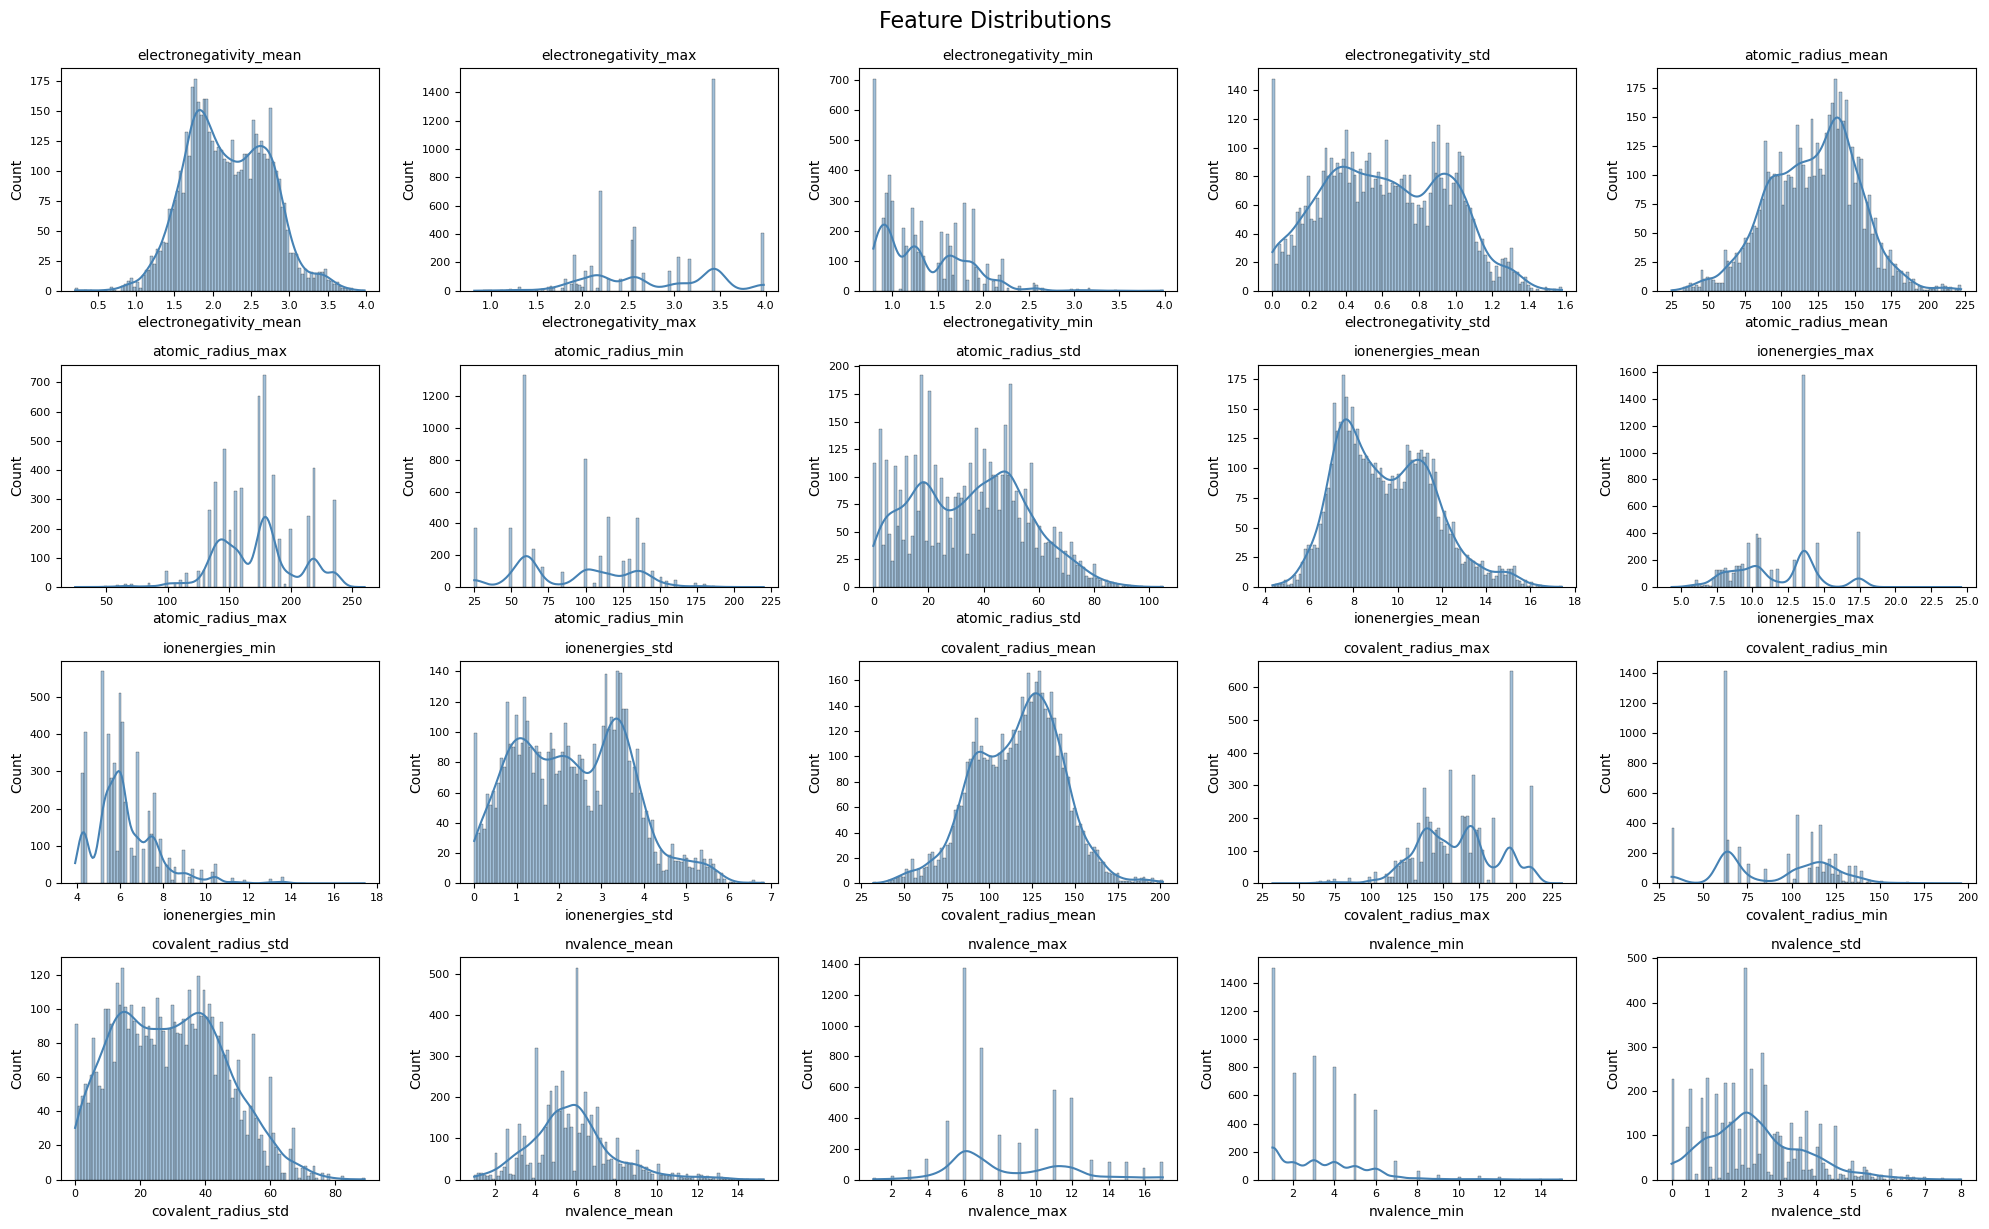

In [183]:
import seaborn as sns

# Define the features to plot
features = [
    'electronegativity_mean', 'electronegativity_max', 'electronegativity_min', 'electronegativity_std',
    'atomic_radius_mean', 'atomic_radius_max', 'atomic_radius_min', 'atomic_radius_std',
    'ionenergies_mean', 'ionenergies_max', 'ionenergies_min', 'ionenergies_std',
    'covalent_radius_mean', 'covalent_radius_max', 'covalent_radius_min', 'covalent_radius_std',
    'nvalence_mean', 'nvalence_max', 'nvalence_min', 'nvalence_std'
]

# Set up the grid
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    sns.histplot(data_df[feature], ax=axes[i], kde=True, bins=100, color='steelblue')
    axes[i].set_title(feature, fontsize=10)
    axes[i].tick_params(labelsize=8)

plt.tight_layout()
plt.suptitle("Feature Distributions", fontsize=16, y=1.02)
plt.show()

In [177]:
print(data_df.columns)

Index(['formula', 'mpid', 'gap opt', 'padded_soap', 'soap_flat',
       'electronegativity_mean', 'electronegativity_max',
       'electronegativity_min', 'electronegativity_std', 'atomic_radius_mean',
       'atomic_radius_max', 'atomic_radius_min', 'atomic_radius_std',
       'ionenergies_mean', 'ionenergies_max', 'ionenergies_min',
       'ionenergies_std', 'covalent_radius_mean', 'covalent_radius_max',
       'covalent_radius_min', 'covalent_radius_std', 'nvalence_mean',
       'nvalence_max', 'nvalence_min', 'nvalence_std'],
      dtype='object')


([<matplotlib.axis.XTick at 0x1ae6f6190>,
 [Text(0, 0, 'No Gap'), Text(1, 0, 'Has Gap')])

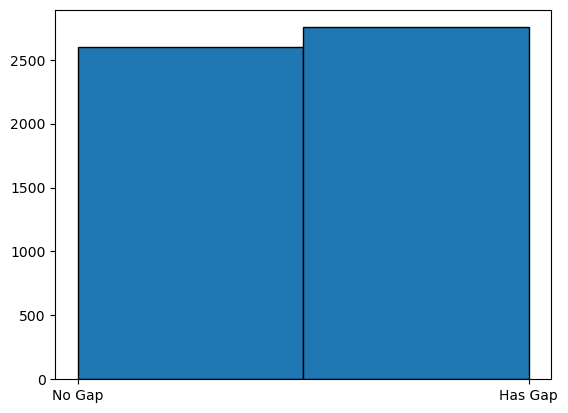

In [175]:
has_gap = data_df['gap opt'] > 1
plt.hist(has_gap.astype(int), bins=2, edgecolor='black')
plt.xticks([0, 1], ['No Gap', 'Has Gap'])

In [188]:
X_atomic = data_df[[
    'electronegativity_mean', 'electronegativity_std', 
    'atomic_radius_mean', 'atomic_radius_std',
    'ionenergies_mean', 'ionenergies_std', 
    'covalent_radius_mean', 'covalent_radius_std',
]]
soaps = np.array(data_df['padded_soap'].tolist())
X_soap_2d = soaps[..., np.newaxis]  # add channel dim: (N, 64, 800, 1)
X_atomic = X_atomic.to_numpy()
# X_combined = np.hstack([np.vstack(data_df['soap_flat']), X_atomic])
print('X_soap_2d shape:', X_soap_2d.shape)
print('X_atomic shape:', X_atomic.shape)
# print('X_combined shape:', X_combined.shape)
print('--------------------')
# Step 2: Split the data into training and testing sets
X_soap_train, X_soap_test, X_atomic_train, X_atomic_test, y_train, y_test = train_test_split(
    X_soap_2d, X_atomic, data_df['gap opt'], test_size=0.2, random_state=42
)

bg_threshold = 0.02 # eV
y_train_binary = (y_train > bg_threshold).astype(int)
y_test_binary = (y_test > bg_threshold).astype(int)

# Flatten the soap descriptors for scaling
X_soap_train_flat = X_soap_train.reshape(X_soap_train.shape[0], -1)
X_soap_test_flat = X_soap_test.reshape(X_soap_test.shape[0], -1)

# scale soap descriptors
scaler_soap = MinMaxScaler()

# Fit and transform the training set, and transform the test set
X_soap_train_scaled = scaler_soap.fit_transform(X_soap_train_flat)
X_soap_test_scaled = scaler_soap.transform(X_soap_test_flat)

# Reshape back to the original shape (N, 64, 800, 1)
X_soap_train_scaled = X_soap_train_scaled.reshape(X_soap_train.shape)
X_soap_test_scaled = X_soap_test_scaled.reshape(X_soap_test.shape)

# scale atomic input data
scaler_atomic = MinMaxScaler()

X_atomic_train_scaled = scaler_atomic.fit_transform(X_atomic_train)
X_atomic_test_scaled = scaler_atomic.transform(X_atomic_test)

print('X_soap_train_scaled shape:', X_soap_train_scaled.shape)
print('X_soap_test_scaled shape:', X_soap_test_scaled.shape)
print('X_atomic_train_scaled shape:', X_atomic_train_scaled.shape)
print('X_atomic_test_scaled shape:', X_atomic_test_scaled.shape)
print('--------------------')
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


X_soap_2d shape: (5352, 64, 800, 1)
X_atomic shape: (5352, 8)
--------------------
X_soap_train_scaled shape: (4281, 64, 800, 1)
X_soap_test_scaled shape: (1071, 64, 800, 1)
X_atomic_train_scaled shape: (4281, 8)
X_atomic_test_scaled shape: (1071, 8)
--------------------
y_train shape: (4281,)
y_test shape: (1071,)


In [189]:
# SOAP input branch
soap_input = Input(shape=(64, 800, 1), name='soap_input')
x = Conv2D(32, (3, 3), activation='relu')(soap_input)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# Periodic table input (8 features)
pt_input = Input(shape=(8,), name='periodic_features')

# Feature group slices (each group has 2 features)
electronegativity = Lambda(lambda t: t[:, 0:2])(pt_input)
atomic_radius     = Lambda(lambda t: t[:, 2:4])(pt_input)
ion_energies      = Lambda(lambda t: t[:, 4:6])(pt_input)
covalent_radius   = Lambda(lambda t: t[:, 6:8])(pt_input)

# Process each group with a small Dense layer
e_dense = Dense(8, activation='relu')(electronegativity)
r_dense = Dense(8, activation='relu')(atomic_radius)
i_dense = Dense(8, activation='relu')(ion_energies)
c_dense = Dense(8, activation='relu')(covalent_radius)

# Concatenate all group representations
y = Concatenate()([e_dense, r_dense, i_dense, c_dense])
y = Dense(64, activation='relu')(y)
y = BatchNormalization()(y)
y = Dense(32, activation='relu')(y)

# Merge with SOAP branch
combined = Concatenate()([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)
z = Dense(1, activation='sigmoid')(z)

# Final model
model = Model(inputs=[soap_input, pt_input], outputs=z)
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

model.summary()

# Compute class weights from labels
y_train_array = np.array(y_train_binary)

# Correctly format the `classes` parameter
classes = np.unique(y_train_array)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_array
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weights_dict)

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ soap_input          │ (None, 64, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 62, 798,   │        320 │ soap_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ periodic_features   │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 31, 399,   │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 2)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 2)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 2)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 2)         │          0 │ periodic_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 399,   │        128 │ max_pooling2d_30… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 8)         │         24 │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 8)         │         24 │ lambda_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 8)         │         24 │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 8)         │         24 │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 29, 397,   │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 32)        │          0 │ dense_53[0][0],   │
│ (Concatenate)       │                   │            │ dense_54[0][0],   │
│                     │                   │            │ dense_55[0][0],   │
│                     │                   │            │ dense_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 14, 198,   │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 64)        │      2,112 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 198,   │        256 │ max_pooling2d_31… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_57[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 36,289 (141.75 KB)

 Trainable params: 35,969 (140.50 KB)

 Non-trainable params: 320 (1.25 KB)

{0: 1.7360097323600974, 1: 0.702263779527559}


In [190]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.001,  # Minimum accuracy improvement required
        patience=5,       # Number of epochs with no improvement to wait
        verbose=1,        # Display messages when stopping
        restore_best_weights=True
    )
]

history = model.fit(
    {'soap_input': X_soap_train, 'periodic_features': X_atomic_train},
    y_train_binary,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
)


Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6743 - auc_5: 0.7735 - loss: 0.5637 - precision_5: 0.8727 - recall_5: 0.6285 - val_accuracy: 0.7608 - val_auc_5: 0.8014 - val_loss: 0.5710 - val_precision_5: 0.7621 - val_recall_5: 0.9776
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8026 - auc_5: 0.8648 - loss: 0.4638 - precision_5: 0.9050 - recall_5: 0.8032 - val_accuracy: 0.7305 - val_auc_5: 0.8566 - val_loss: 0.8926 - val_precision_5: 0.7305 - val_recall_5: 1.0000
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7965 - auc_5: 0.8603 - loss: 0.4706 - precision_5: 0.9083 - recall_5: 0.7907 - val_accuracy: 0.7305 - val_auc_5: 0.8681 - val_loss: 1.0601 - val_precision_5: 0.7305 - val_recall_5: 1.0000
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8028 - auc_5: 0.8717 - loss: 0.4471 - precision_5: 0.9105 - recall_5: 0.8050 - val_accuracy: 0.7305 - val_auc_5: 0.8878 - val_loss: 0.9685 - val_precision_5: 0.7305 - v

In [193]:
model.save('/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/models/bandgap_classifier_pt_slicing_std_avg.h5')
model.save('/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/models/bandgap_classifier_pt_slicing_std_avg.keras')

In [191]:
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    {'soap_input': X_soap_test, 'periodic_features': X_atomic_test},
    y_test_binary,  # Use binary labels
    verbose=0
)
print(f"Test Accuracy: {test_acc:.3f}, Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, AUC: {test_auc:.3f}")

Test Accuracy: 0.808, Precision: 0.942, Recall: 0.781, AUC: 0.905


34/34 - 7s - 201ms/step - accuracy: 0.8077 - auc_5: 0.9047 - loss: 0.4299 - precision_5: 0.9420 - recall_5: 0.7805

Evaluation metrics: {'loss': 0.4299430549144745, 'compile_metrics': 0.8076564073562622}
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step

Classification Report:
              precision    recall  f1-score   support

      No Gap       0.61      0.88      0.72       301
     Has Gap       0.94      0.78      0.85       770

    accuracy                           0.81      1071
   macro avg       0.78      0.83      0.79      1071
weighted avg       0.85      0.81      0.82      1071


Confusion Matrix:


Text(0, 0.5, 'True')

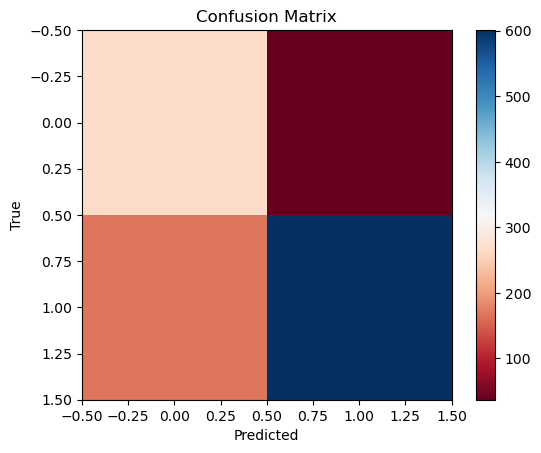

In [192]:
results = model.evaluate(
    {'soap_input': X_soap_test, 'periodic_features': X_atomic_test},
    y_test_binary,
    verbose=2
)

print("\nEvaluation metrics:", dict(zip(model.metrics_names, results)))

# prediction
y_pred_probs = model.predict({'soap_input': X_soap_test, 'periodic_features': X_atomic_test})
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred, target_names=['No Gap', 'Has Gap']))

print("\nConfusion Matrix:")
plt.imshow(confusion_matrix(y_test_binary, y_pred), cmap='RdBu', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# print(confusion_matrix(y_test_binary, y_pred))

# Neural Net only using atomic info

In [150]:
# Define periodic table feature columns
pt_columns = [
    'electronegativity_mean', 'electronegativity_max', 'electronegativity_min', 'electronegativity_std',
    'atomic_radius_mean', 'atomic_radius_max', 'atomic_radius_min', 'atomic_radius_std',
    'ionenergies_mean', 'ionenergies_max', 'ionenergies_min', 'ionenergies_std',
    'covalent_radius_mean', 'covalent_radius_max', 'covalent_radius_min', 'covalent_radius_std',
    'nvalence_mean', 'nvalence_max', 'nvalence_min', 'nvalence_std'
]

# Extract features and labels
X = data_df[pt_columns].values
y = data_df['gap opt'].values

print('y shape:', y.shape)
print('X shape:', X.shape)
print('----------------')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print('X_train_scaled shape:', X_train_scaled.shape)
print('X_test_scaled shape:', X_test_scaled.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

# Compute class weights
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights_dict = dict(zip(classes, class_weights))


y shape: (5352,)
X shape: (5352, 20)
----------------
X_train_scaled shape: (4281, 20)
X_test_scaled shape: (1071, 20)
y_train shape: (4281,)
y_test shape: (1071,)


In [151]:

# Build NN model
pt_input = Input(shape=(X_train_scaled.shape[1],), name='periodic_features')
x = Dense(64, activation='relu')(pt_input)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pt_input, outputs=output)
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# Model summary
model.summary()





Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ periodic_features (InputLayer)  │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,081 (23.75 KB)

 Trainable params: 5,825 (22.75 KB)

 Non-trainable params: 256 (1.00 KB)

In [154]:
# Train
model.fit(X_train_scaled, y_train,
          validation_data=(X_test_scaled, y_test),
          epochs=50,
          batch_size=32,
          class_weight=class_weights_dict,
          verbose=2)


Epoch 1/50
134/134 - 0s - 3ms/step - accuracy: 2.3359e-04 - auc_3: 0.8915 - loss: -9.1343e+03 - precision_3: 1.0000 - recall_3: 0.7797 - val_accuracy: 0.0019 - val_auc_3: 0.7043 - val_loss: -7.8611e+03 - val_precision_3: 0.9987 - val_recall_3: 0.7425
Epoch 2/50
134/134 - 0s - 3ms/step - accuracy: 2.3359e-04 - auc_3: 0.8933 - loss: -9.5024e+03 - precision_3: 1.0000 - recall_3: 0.7855 - val_accuracy: 9.3371e-04 - val_auc_3: 0.6028 - val_loss: -9.4449e+03 - val_precision_3: 0.9979 - val_recall_3: 0.8764
Epoch 3/50
134/134 - 0s - 3ms/step - accuracy: 2.3359e-04 - auc_3: 0.8884 - loss: -9.8412e+03 - precision_3: 1.0000 - recall_3: 0.7757 - val_accuracy: 0.0028 - val_auc_3: 0.8783 - val_loss: -9.0937e+03 - val_precision_3: 1.0000 - val_recall_3: 0.7528
Epoch 4/50
134/134 - 0s - 3ms/step - accuracy: 2.3359e-04 - auc_3: 0.8932 - loss: -1.0167e+04 - precision_3: 1.0000 - recall_3: 0.7860 - val_accuracy: 9.3371e-04 - val_auc_3: 0.5847 - val_loss: -9.5752e+03 - val_precision_3: 0.9978 - val_recal

In [153]:
# Evaluate
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(dict(zip(model.metrics_names, results)))

{'loss': -8025.791015625, 'compile_metrics': 0.00186741363722831}


In [ ]:
# plt.plot(X_combined[0])

In [ ]:
xgb = XGBRegressor(verbosity=2)
xgb.fit(X_train, y_train)

XGBoostError: [15:32:43] /Users/runner/miniforge3/conda-bld/xgboost-split_1745056754219/work/src/data/data.cc:542: Check failed: this->labels.Size() % this->num_row_ == 0 (2599 vs. 0) : Incorrect size for labels: (2599,1) v.s. 2602
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001a0896a15 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x00000001a0a4d249 xgboost::MetaInfo::SetInfoFromHost(xgboost::Context const*, xgboost::StringView, xgboost::Json) + 3513
  [bt] (2) 3   libxgboost.dylib                    0x00000001a0a4c380 xgboost::MetaInfo::SetInfo(xgboost::Context const&, xgboost::StringView, xgboost::StringView) + 496
  [bt] (3) 4   libxgboost.dylib                    0x00000001a08ada21 XGDMatrixSetInfoFromInterface + 257
  [bt] (4) 5   libffi.8.dylib                      0x000000010ae1598a ffi_call_unix64 + 82
  [bt] (5) 6   ???                                 0x00007ff7b6086df0 0x0 + 140701887655408



In [ ]:
# model_path = "/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/xgb_model_all_data_oob.pkl"
# with open(model_path, "wb") as model_file:
#     pickle.dump(xgb, model_file)
# print(f"Model saved to {model_path}")

Model saved to /Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/xgb_model_all_data_oob.pkl


XGBoost MAE: 0.7283


Text(0, 0.5, 'predicted bandgap')

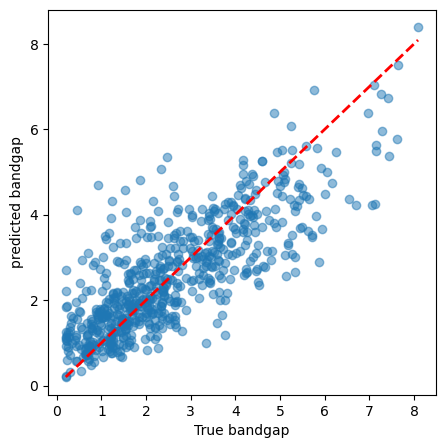

In [ ]:
xgb_pred = xgb.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print(f"XGBoost MAE: {xgb_mae:.4f}")
# Plotting the predictions
plt.figure(figsize=(5, 5))
plt.scatter(y_test, xgb_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True bandgap')
plt.ylabel('predicted bandgap')


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step


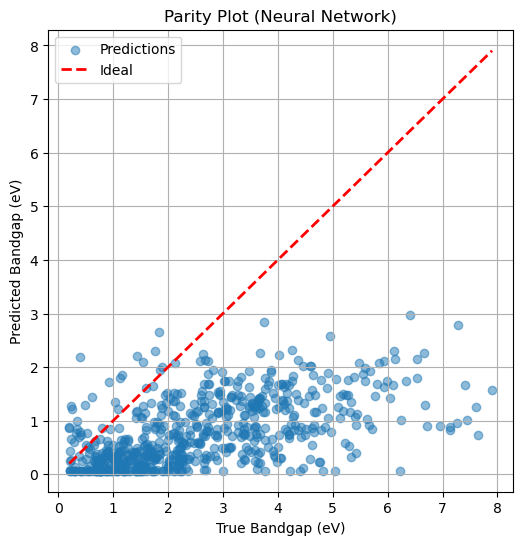

In [ ]:
y_pred = model.predict({'soap_input': X_soap_test, 'periodic_features': X_atomic_test})

# Parity plot for predicted vs true bandgap values (Neural Network)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('True Bandgap (eV)')
plt.ylabel('Predicted Bandgap (eV)')
plt.title('Parity Plot (Neural Network)')
plt.legend()
plt.grid(True)
plt.show()